# (03) Combine neural fits (subset)

**Motivation**: ...across different sim categories & analyze <br>

In [1]:
# HIDE CODE


import os, sys
from IPython.display import display

# tmp & extras dir
git_dir = os.path.join(os.environ['HOME'], 'Dropbox/git')
extras_dir = os.path.join(git_dir, 'jb-MTMST/_extras')
fig_base_dir = os.path.join(git_dir, 'jb-MTMST/figs')
tmp_dir = os.path.join(git_dir, 'jb-MTMST/tmp')

# GitHub
sys.path.insert(0, os.path.join(git_dir, '_MTMST'))
from vae.train_vae import TrainerVAE, ConfigTrainVAE
from vae.vae2d import VAE, ConfigVAE
from figures.fighelper import *
from analysis.glm import *


# warnings, tqdm, & style
warnings.filterwarnings('ignore', category=DeprecationWarning)
from rich.jupyter import print
%matplotlib inline
set_style()

## Copy fits to tmp dir

In [2]:
fits = [
    'fixate0_nf-80_(2023_04_28,22:46)',
    'fixate1_nf-420_(2023_04_27,20:20)',
    # 'fixate2_nf-420_(2023_04_27,13:57)',
    # 'fixate2_nf-420_(2023_04_28,12:46)', # local to GABAN, currently not used
    # 'fixate4_nf-420_(2023_04_28,16:15)',
    # 'fixate8_nf-420_(2023_04_28,14:34)',

    'transl0_nf-70_(2023_04_27,13:30)',
    'transl1_nf-420_(2023_04_27,13:00)',
    # 'transl2_nf-420_(2023_04_27,19:16)',
    # 'transl4_nf-420_(2023_04_27,07:52)',
    # 'transl8_nf-420_(2023_04_30,07:48)',

    'obj1_nf-280_(2023_04_26,15:53)',
    # 'obj2_nf-280_(2023_05_01,07:39)',
    # 'obj4_nf-280_(2023_04_26,18:21)',
    # 'obj8_nf-420_(2023_04_28,12:48)',

    # 'terrain1_nf-210_(2023_04_27,12:50)',
    # 'terrain2_nf-420_(2023_04_28,15:15)',
    # 'terrain4_nf-420_(2023_04_28,14:08)',
    # 'terrain8_nf-420_(2023_04_26,22:51)',
]
copy_fits(fits, pjoin(tmp_dir, 'results_combined'))

## Load & analyze

In [3]:
df = []
perf = {}
for fit_name in fits:
    _df = f"summary_{fit_name}.df"
    _df = pjoin(tmp_dir, 'results_combined', _df)
    _df = pd.read_pickle(_df)
    k = _df['category'].unique().item()
    perf[k] = _df.perf.values
    df.append(_df)
df = pd.concat(df)
print({k: len(v) for k, v in perf.items()})

{'fixate0': 141, 'fixate1': 141, 'transl0': 141, 'transl1': 141, 'obj1': 141}

In [4]:
grouped_by_cat = collections.defaultdict(list)
grouped_by_nobj = collections.defaultdict(list)
for sim in df['category'].unique():
    cat, n = sim[:-1], int(sim[-1])
    grouped_by_cat[cat].append(n)
    grouped_by_nobj[n].append(cat)
grouped_by_cat = dict(grouped_by_cat)
grouped_by_nobj = dict(grouped_by_nobj)

print(grouped_by_cat)
print(grouped_by_nobj)

{'fixate': [0, 1], 'transl': [0, 1], 'obj': [1]}

{0: ['fixate', 'transl'], 1: ['fixate', 'transl', 'obj']}

In [5]:
pal = {}
colors = ['Blues', 'Oranges', 'Greens', 'Purples', 'Greys']
for c, (k, v) in zip(colors, grouped_by_cat.items()):
    _pal = sns.color_palette(c, n_colors=len(v) + 3)[1:-2]
    for i in range(len(v)):
        pal[f"{k}{v[i]}"] = _pal[i]

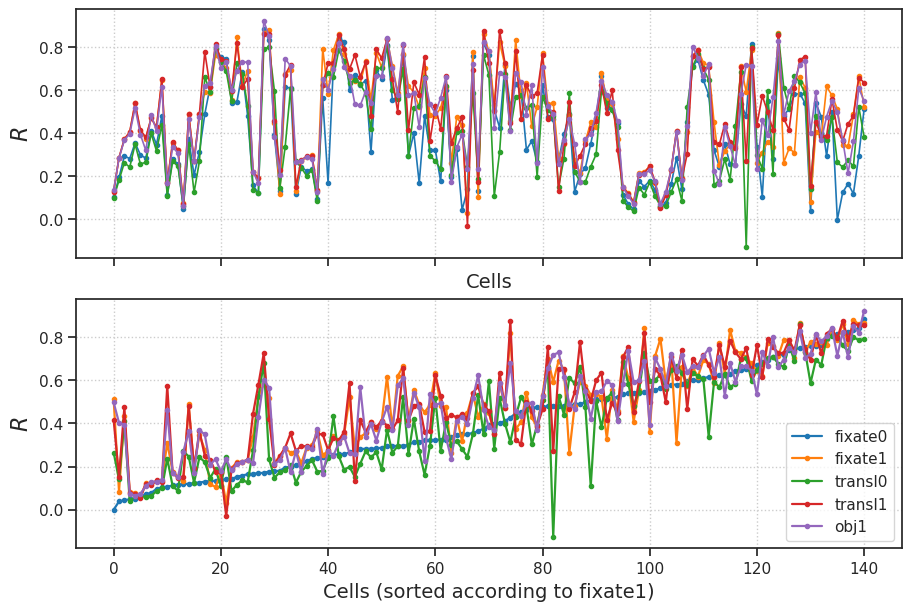

In [6]:
# HIDE CODE


sorted_data = sorted(
    zip(*(v for v in perf.values())),
    key=lambda x: x[0],
)
sorted_data = tuple(zip(*sorted_data))


fig, axes = create_figure(2, 1, (9, 6), 'all', layout='constrained')

for k, v in perf.items():
    axes[0].plot(v, marker='.', lw=1.2, label=k)
axes[0].set_xlabel('Cells', fontsize=14)

for k, v in zip(perf, sorted_data):
    axes[1].plot(v, marker='.', lw=1.6, label=k)
axes[1].set_xlabel('Cells (sorted according to fixate1)', fontsize=14)
axes[1].legend()

for ax in axes.flat:
    ax.set_ylabel(r'$R$', fontsize=16)
    ax.grid()

plt.show()

In [7]:
# HIDE CODE


x = np.stack([v for v in perf.values()])

counts = collections.Counter(np.argmax(x, axis=0))
counts = {
    list(perf)[i]: c for i, c
    in counts.most_common()
}
counts = {
    k: counts.get(k, 0) for k
    in list(counts) + list(perf)
}

percent = {
    k: np.round(100 * v / sum(counts.values()), 1)
    for k, v in counts.items()
}
print(percent)

{'transl1': 34.0, 'fixate1': 30.5, 'obj1': 24.1, 'transl0': 6.4, 'fixate0': 5.0}

In [8]:
best = x.max(0)
x = best.mean()
x

0.5351586222201331

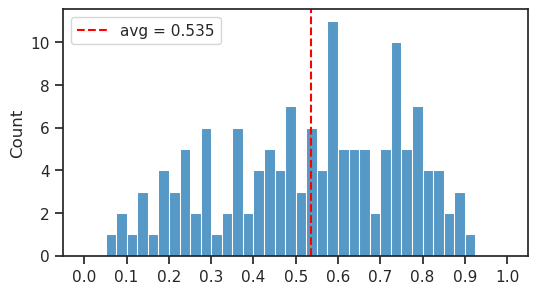

In [9]:
fig, ax = create_figure(1, 1, (6, 3.2))
sns.histplot(best, bins=np.linspace(0, 1, 41), ax=ax)
ax.axvline(x, color='r', ls='--', label=f"avg = {x:0.3f}")
ax.locator_params(axis='x', nbins=11)
ax.legend()
plt.show()

In [10]:
patrick = 100 * (best.mean() - .251) / .251
res = 100 * (best.mean() - .447) / .447

msg = f"outperforming patrick: {patrick:0.0f} %"
msg += f"\noutperforming reservoir: {res:0.0f} %"
print(msg)

outperforming patrick: 113 %
outperforming reservoir: 20 %

## More plots

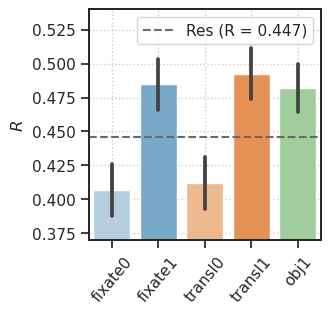

In [11]:
# HIDE CODE


fig, ax = create_figure(1, 1, (3, 3))
sns.barplot(
    data=df,
    x='category',
    y='perf',
    hue='category',
    palette=pal,
    errorbar='se',
    dodge=False,
    ax=ax,
)
ax.get_legend().remove()
ax.set(xlabel='', ylabel=r'$R$', ylim=(0.37, 0.54))
ax.tick_params(axis='x', rotation=50)
ax.grid()

axtwix = ax.twinx()
res_r = 0.447
axtwix.axhline(res_r, color='dimgrey', ls='--', label=f'Res (R = {res_r})')
axtwix.set(yticks=[])
axtwix.legend()

plt.show()

## Get df best

In [12]:
df_best = best_fits(df)

inds = df_best['perf_best'].argsort()[::-1]
df_best.iloc[inds[:20]]

,index,category,nf,root,expt,cell,max_perf,log_alpha,best_lag,beta,perf_best,perf_worst,perf_mu,perf_sd,%+,%-
28,28,obj1,280,YUWEI,clu116,0,0.835483,16.0,0,0.15,0.923867,0.792150,0.865665,0.047949,6.723283,-8.492310
29,29,fixate1,420,YUWEI,clu120,0,0.967720,4.0,3,0.15,0.882615,0.801259,0.846220,0.030735,4.300976,-5.313107
72,72,transl1,420,YUWEI,clu267,7,0.955361,2.0,5,0.15,0.876347,0.313269,0.624023,0.245711,40.435104,-49.798472
69,69,transl1,420,YUWEI,clu267,4,0.979806,2.0,5,0.15,0.876143,0.763639,0.830054,0.044115,5.552474,-8.001362
124,124,fixate1,420,YUWEI,ytu029,4,0.935583,6.0,3,0.15,0.867652,0.749052,0.833183,0.049176,4.137000,-10.097576
42,42,fixate1,420,YUWEI,clu209,1,0.923722,8.0,2,0.15,0.860105,0.786781,0.833945,0.030331,3.136865,-5.655474
23,23,fixate1,420,YUWEI,clu104,0,0.980831,0.0,4,0.15,0.845799,0.547027,0.725777,0.118461,16.537078,-24.628786
51,51,obj1,280,YUWEI,clu221,3,0.900849,8.0,3,0.15,0.843850,0.804119,0.826916,0.018849,2.047912,-2.756911
75,75,fixate1,420,YUWEI,clu267,11,0.850368,-10.0,6,0.15,0.835265,0.569120,0.699820,0.109300,19.354368,-18.676186
43,43,fixate0,80,YUWEI,clu209,4,0.933615,-6.0,3,NaN,0.826528,0.707503,0.765950,0.046596,7.908857,-7.630748


In [13]:
inds = df_best['%+'].argsort()[::-1]
df_best.iloc[inds[:10]]

,index,category,nf,root,expt,cell,max_perf,log_alpha,best_lag,beta,perf_best,perf_worst,perf_mu,perf_sd,%+,%-
130,130,obj1,280,YUWEI,ytu029,12,0.324496,14.0,0,0.15,0.403154,0.037902,0.163689,0.141651,146.292206,-76.845080
66,66,transl0,70,YUWEI,clu229,11,0.716168,14.0,2,NaN,0.244964,-0.029625,0.123934,0.121690,97.657026,-123.903548
118,118,obj1,280,YUWEI,ytu028,8,0.328052,12.0,10,0.15,0.718525,-0.127204,0.387300,0.331135,85.521363,-132.843705
121,121,transl1,420,YUWEI,ytu029,1,0.879469,-6.0,11,0.15,0.574717,0.105880,0.337828,0.184755,70.121315,-68.658557
79,79,transl1,420,YUWEI,clu292,2,0.805540,4.0,10,0.15,0.587479,0.198308,0.367203,0.174860,59.987505,-45.995036
123,123,obj1,280,YUWEI,ytu029,3,0.668747,1.0,6,0.15,0.568364,0.212971,0.363177,0.136629,56.497823,-41.358780
137,137,transl1,420,YUWEI,ytu029,20,0.958395,3.0,5,0.15,0.444701,0.166465,0.288164,0.108955,54.322052,-42.232519
135,135,fixate1,420,YUWEI,ytu029,18,0.934164,-6.0,9,0.15,0.513141,-0.001117,0.338164,0.213645,51.743142,-100.330173
112,112,fixate1,420,YUWEI,clu295,10,0.947970,14.0,12,0.15,0.451139,0.161606,0.304419,0.113207,48.196553,-46.913290
63,63,transl1,420,YUWEI,clu227,0,0.857890,5.0,12,0.15,0.354392,0.173195,0.239178,0.072414,48.170691,-27.587353


In [14]:
sorted_data = sorted(zip(
    df_best['perf_best'],
    df_best['perf_mu'],
    df_best['perf_sd'],
), key=lambda x: x[0])
sorted_data = list(map(
    lambda t: np.array(t),
    zip(*sorted_data),
))

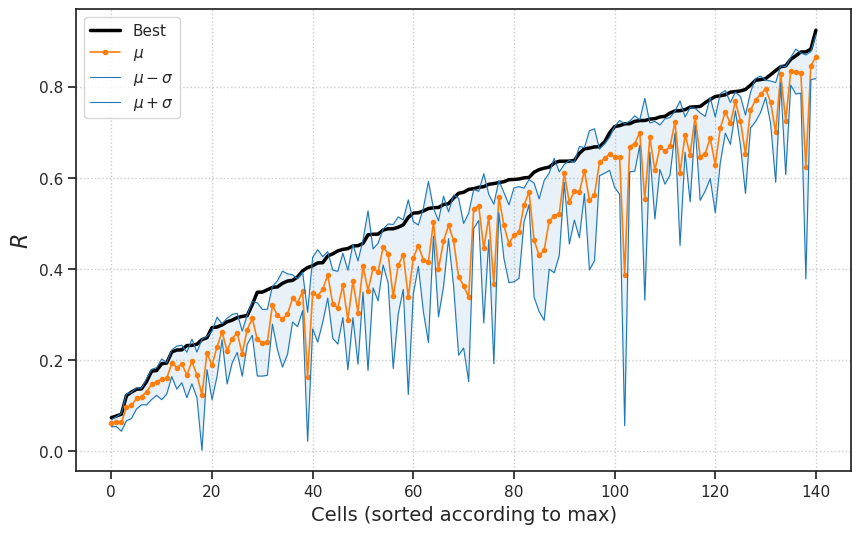

In [15]:
# HIDE CODE


fig, ax = create_figure(1, 1, (10, 6))
ax.plot(sorted_data[0], lw=2.5, color='k', label='Best')
ax.plot(sorted_data[1], lw=1.2, color='C1', marker='.', label=r'$\mu$')

lower = sorted_data[1] - sorted_data[2]
higher = sorted_data[1] + sorted_data[2]
ax.plot(lower, lw=0.8, color='C0', label=r'$\mu - \sigma$')
ax.plot(higher, lw=0.8, color='C0', label=r'$\mu + \sigma$')
ax.fill_between(
    x=range(len(df_best)),
    y1=lower,
    y2=higher,
    color='C0',
    alpha=0.1,
)
ax.set_xlabel('Cells (sorted according to max)', fontsize=14)
ax.set_ylabel(r'$R$', fontsize=16)
ax.locator_params(axis='y', nbins=10)
ax.legend()
ax.grid()
plt.show()

### Pie chart

In [16]:
labels, vals = zip(*collections.Counter(
    df_best['category']).most_common())
vals = [100 * e / sum(vals) for e in vals]

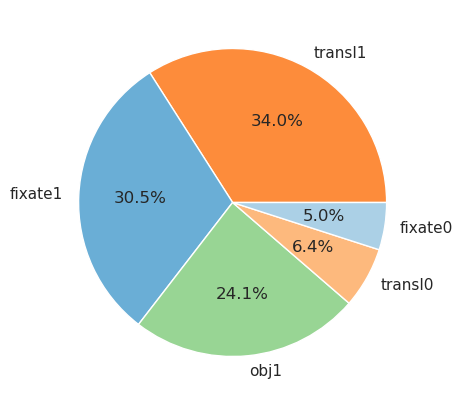

In [17]:
fig, ax = create_figure(1, 1, (6, 5))
ax.pie(
    x=vals,
    labels=labels,
    colors=[pal[e] for e in labels],
    autopct='%0.1f%%',
)
plt.show()

### Summary of results

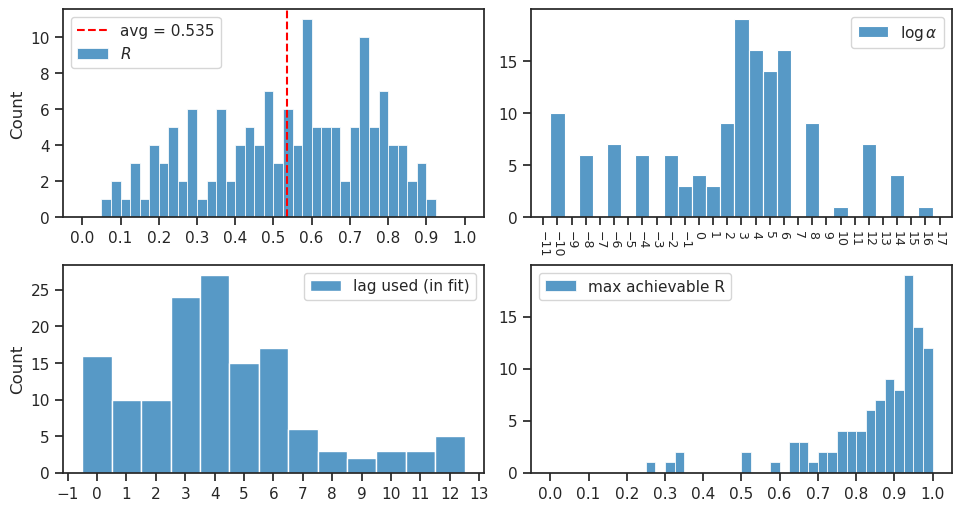

In [18]:
show_neural_results(df_best, 'perf_best');

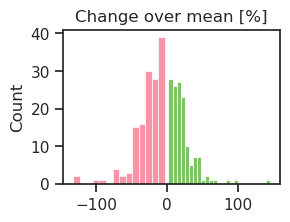

In [19]:
_pal = sns.color_palette('husl')
_pal = {'+': _pal[2], '-': _pal[0]}

fig, ax = create_figure(1, 1, (2.8, 2))
sns.histplot(df_best['%+'], color=_pal['+'], ax=ax)
sns.histplot(df_best['%-'], color=_pal['-'], ax=ax)
ax.set(xlabel='', title='Change over mean [%]')
plt.show()

In [20]:
val = np.concatenate([df_best['%+'].values, df_best['%-'].values])
label = ['+'] * len(df_best['%+']) + ['-'] * len(df_best['%-'])

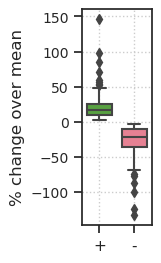

In [21]:
fig, ax = create_figure(1, 1, (0.9, 2.8))

sns.boxplot(
    data=pd.DataFrame({'val': val, 'label': label}),
    y='val',
    x='label',
    palette=_pal,
    width=0.70,
    ax=ax,
)
ax.tick_params(axis='y', labelsize=10)
ax.set(xlabel='', ylabel='% change over mean')
ax.grid()
plt.show()

## Delta

<Axes: ylabel='Count'>

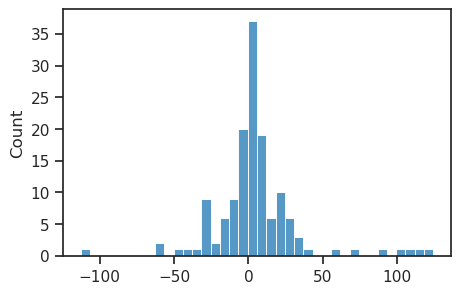

In [53]:
delta = 100 * (perf['transl1'] - perf['obj1']) / perf['obj1']
sns.histplot(delta)

In [54]:
inds = np.argsort(delta)[::-1]
perf['transl1'][inds[:5]], perf['obj1'][inds[:5]]

(array([0.58747934, 0.3492635 , 0.44470093, 0.3543917 , 0.43963464]),
 array([0.26205165, 0.16407978, 0.21458757, 0.17319512, 0.233177  ]))

In [59]:
inds = np.argsort(perf['transl1'])[::-1]
perf['transl1'][inds[:5]], perf['obj1'][inds[:5]]

(array([0.87634698, 0.876143  , 0.86199085, 0.85958291, 0.85727045]),
 array([0.68086086, 0.82501167, 0.85149622, 0.92386653, 0.82219205]))

In [60]:
df.loc[df['category'] == 'transl1'].iloc[inds[0]]

category      transl1
nf                420
root            YUWEI
expt           clu267
cell                7
perf         0.876347
max_perf     0.955361
log_alpha         2.0
best_lag            5
beta             0.15
Name: 72, dtype: object

In [61]:
df.loc[df['category'] == 'obj1'].iloc[inds[0]]

category         obj1
nf                280
root            YUWEI
expt           clu267
cell                7
perf         0.680861
max_perf     0.955361
log_alpha       -10.0
best_lag            5
beta             0.15
Name: 72, dtype: object

In [62]:
df.loc[df['category'] == 'fixate1'].iloc[inds[0]]

category      fixate1
nf                420
root            YUWEI
expt           clu267
cell                7
perf         0.822338
max_perf     0.955361
log_alpha         4.0
best_lag            4
beta             0.15
Name: 72, dtype: object

In [63]:
fit_name = fits[3]
print(fit_name)

transl1_nf-420_(2023_04_27,13:00)

In [64]:
expt = 'clu267'
kws = dict(tr=None, root='YUWEI', expt=expt)
ro = Neuron(**kws).load(fit_name, 'cuda:1')

In [65]:
data = ro.validate(7)

In [66]:
list(data)

['x', 'y', 'x_tst', 'y_tst']

In [67]:
data['y'].sum() / (len(data['y']) * 25e-3)

16.221475226148506

In [69]:
pred = ro.mod[7].predict(data['x_tst'])

In [70]:
sp_stats.pearsonr(data['y_tst'], pred)

(0.8372280722387222, 4.619487503401474e-54)

In [71]:
sk_metric.r2_score(data['y_tst'], pred)

0.6094886832665495

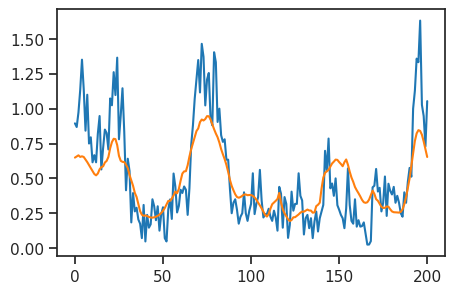

In [72]:
plt.plot(data['y_tst'])
plt.plot(pred)

In [74]:
ro.df[7]

,r,nnll,r_tst,r2_tst
alpha,,,,
1.000000e-08,NaN,NaN,0.824939,61.142743
1.000000e-06,NaN,NaN,0.824403,61.115498
1.000000e-04,NaN,NaN,0.824966,61.032373
1.000000e-02,NaN,NaN,0.827364,61.632044
1.000000e-01,NaN,NaN,0.829166,61.549678
1.000000e+00,NaN,NaN,0.829350,61.026728
1.000000e+01,NaN,NaN,0.835617,61.099603
1.000000e+02,NaN,NaN,0.837228,60.948868
1.000000e+03,NaN,NaN,0.825455,59.143117


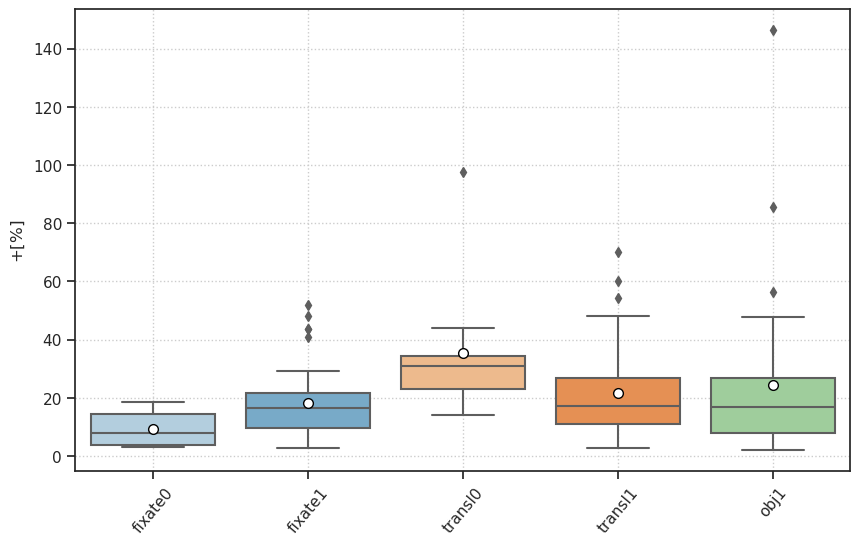

In [23]:
# HIDE CODE


props_mean = {
    'marker': 'o',
    'markerfacecolor': 'white',
    'markeredgecolor': 'k',
    'markersize': 7,
    'alpha': 1.0,
}

fig, ax = create_figure(1, 1, (10, 6))
sns.boxplot(
    data=df_best,
    y='%+',
    x='category',
    hue='category',
    order=pal,
    palette=pal,
    dodge=False,
    showmeans=True,
    meanprops=props_mean,
    ax=ax,
)
ax.set(xlabel='', ylabel=r'$+ [\%]$')
ax.tick_params(axis='x', rotation=50)
ax.get_legend().remove()
ax.grid()
plt.show()

In [24]:
categories = list(df['category'].unique())
df_test = best_fits(df, categories)
perf_best = df_test['perf_best'].mean()
perf_best

0.5351586222201329

In [25]:
reduced_perf = {}
for cat in grouped_by_cat:
    _df = best_fits(df, [e for e in categories if cat not in e])
    reduced_perf[cat] = _df['perf_best'].mean()
print(reduced_perf)

{'fixate': 0.5260211154638904, 'transl': 0.5183453091871347, 'obj': 0.525539224768023}

In [26]:
reduced_perf_objs = {}
for n_obj in grouped_by_nobj:
    _df = best_fits(df, [e for e in categories if int(e[-1]) == n_obj])
    reduced_perf_objs[n_obj] = _df['perf_best'].mean()
print(reduced_perf_objs)

{0: 0.44796809884141836, 1: 0.5289795699639248}

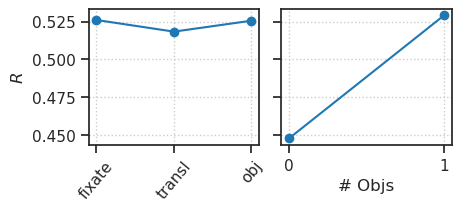

In [27]:
fig, axes = create_figure(1, 2, (4.5, 2), sharey='all', layout='constrained')

axes[0].plot(list(reduced_perf.values()), marker='o')
axes[0].set(xticks=range(len(reduced_perf)), xticklabels=list(reduced_perf), ylabel=r'$R$')
axes[0].tick_params(axis='x', rotation=50)
axes[0].grid()

axes[1].plot(list(reduced_perf_objs.values()), marker='o')
axes[1].set(xticks=range(len(reduced_perf_objs)), xticklabels=list(reduced_perf_objs), xlabel='# Objs')
axes[1].tick_params(axis='x', rotation=0)
axes[1].grid()

plt.show()

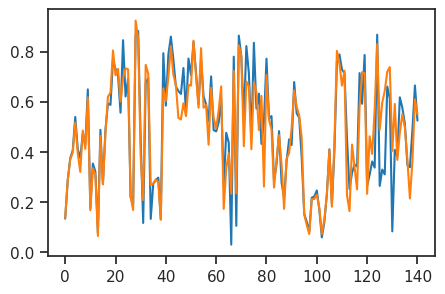

In [28]:
plt.plot(df.loc[df['category'] == 'fixate1', 'perf'].values)
plt.plot(df.loc[df['category'] == 'obj1', 'perf'].values)

## Permutation test

In [28]:
%%time

def statistic(a, b):
    return np.mean(a - b)


t = PrettyTable()
t.field_names = [
    'Category #1',
    'Category #2',
    'Statistic',
    'p-val',
    'Significant?',
]

pvals = {}
looper = itertools.combinations(
    list(df['category'].unique()), 2)
for c1, c2 in looper:
    _data = (
        df.loc[df['category'] == c1, 'perf'].values,
        df.loc[df['category'] == c2, 'perf'].values,
    )
    test = sp_stats.permutation_test(
        data=_data,
        n_resamples=int(1e5),
        permutation_type='samples',
        alternative='two-sided',
        statistic=statistic,
        random_state=0,
    )
    pvals[(c1, c2)] = test.pvalue
    t.add_row([
        c1,
        c2,
        np.round(test.statistic, 2),
        f"{test.pvalue:0.2g}",
        test.pvalue < 0.05,
    ])

CPU times: user 1h 15min 21s, sys: 2min 5s, total: 1h 17min 26s
Wall time: 1h 17min 26s


In [29]:
print(t)

+-------------+-------------+-----------+---------+--------------+
| Category #1 | Category #2 | Statistic |  p-val  | Significant? |
+-------------+-------------+-----------+---------+--------------+
|   fixate0   |   fixate1   |   -0.08   |  2e-05  |     True     |
|   fixate0   |   fixate2   |   -0.05   |  2e-05  |     True     |
|   fixate0   |   fixate4   |   -0.07   |  2e-05  |     True     |
|   fixate0   |   fixate8   |   -0.05   |  2e-05  |     True     |
|   fixate0   |   transl0   |    -0.0   |   0.65  |    False     |
|   fixate0   |   transl1   |   -0.09   |  2e-05  |     True     |
|   fixate0   |   transl2   |   -0.07   |  2e-05  |     True     |
|   fixate0   |   transl4   |   -0.07   |  2e-05  |     True     |
|   fixate0   |   transl8   |   -0.05   |  6e-05  |     True     |
|   fixate0   |     obj1    |   -0.07   |  2e-05  |     True     |
|   fixate0   |     obj2    |   -0.05   |  2e-05  |     True     |
|   fixate0   |     obj4    |   -0.05   |  2e-05  |     True     |
|   fixate0   |     obj8    |   -0.06   |  2e-05  |     True     |
|   fixate0   |   terrain1  |   -0.02   |  0.023  |     True     |
|   fixate0   |   terrain2  |   -0.04   | 0.00046 |     True     |
|   fixate0   |   terrain4  |   -0.03   |  0.0034 |     True     |
|   fixate0   |   terrain8  |   -0.04   |  2e-05  |     True     |
|   fixate1   |   fixate2   |    0.02   |  0.0025 |     True     |
|   fixate1   |   fixate4   |    0.0    |   0.7   |    False     |
|   fixate1   |   fixate8   |    0.03   | 0.00052 |     True     |
|   fixate1   |   transl0   |    0.07   |  2e-05  |     True     |
|   fixate1   |   transl1   |   -0.01   |   0.25  |    False     |
|   fixate1   |   transl2   |    0.01   |   0.55  |    False     |
|   fixate1   |   transl4   |    0.01   |   0.33  |    False     |
|   fixate1   |   transl8   |    0.03   | 0.00016 |     True     |
|   fixate1   |     obj1    |    0.0    |   0.72  |    False     |
|   fixate1   |     obj2    |    0.02   |  0.0019 |     True     |
|   fixate1   |     obj4    |    0.02   |  0.0074 |     True     |
|   fixate1   |     obj8    |    0.02   |   0.04  |     True     |
|   fixate1   |   terrain1  |    0.05   |  2e-05  |     True     |
|   fixate1   |   terrain2  |    0.04   | 0.00016 |     True     |
|   fixate1   |   terrain4  |    0.05   |  2e-05  |     True     |
|   fixate1   |   terrain8  |    0.03   | 0.00086 |     True     |
|   fixate2   |   fixate4   |   -0.02   |  0.012  |     True     |
|   fixate2   |   fixate8   |    0.0    |   0.52  |    False     |
|   fixate2   |   transl0   |    0.05   |  6e-05  |     True     |
|   fixate2   |   transl1   |   -0.03   |  0.0004 |     True     |
|   fixate2   |   transl2   |   -0.02   |  0.015  |     True     |
|   fixate2   |   transl4   |   -0.02   |  0.057  |    False     |
|   fixate2   |   transl8   |    0.01   |   0.41  |    False     |
|   fixate2   |     obj1    |   -0.02   |  0.0086 |     True     |
|   fixate2   |     obj2    |    -0.0   |    1    |    False     |
|   fixate2   |     obj4    |    0.0    |   0.9   |    False     |
|   fixate2   |     obj8    |   -0.01   |   0.37  |    False     |
|   fixate2   |   terrain1  |    0.03   |  0.0072 |     True     |
|   fixate2   |   terrain2  |    0.02   |   0.12  |    False     |
|   fixate2   |   terrain4  |    0.03   |   0.01  |     True     |
|   fixate2   |   terrain8  |    0.01   |   0.26  |    False     |
|   fixate4   |   fixate8   |    0.03   |  0.0021 |     True     |
|   fixate4   |   transl0   |    0.07   |  2e-05  |     True     |
|   fixate4   |   transl1   |   -0.01   |   0.17  |    False     |
|   fixate4   |   transl2   |    0.0    |   0.8   |    False     |
|   fixate4   |   transl4   |    0.01   |   0.58  |    False     |
|   fixate4   |   transl8   |    0.03   | 0.00064 |     True     |
|   fixate4   |     obj1    |    -0.0   |   0.98  |    False     |
|   fixate4   |     obj2    |    0.02   |  0.0073 |     True     |
|   fixate4   |     obj4    |    0.02   |  0.01

In [30]:
print(pvals)

{
    ('fixate0', 'fixate1'): 1.999980000199998e-05,
    ('fixate0', 'fixate2'): 1.999980000199998e-05,
    ('fixate0', 'fixate4'): 1.999980000199998e-05,
    ('fixate0', 'fixate8'): 1.999980000199998e-05,
    ('fixate0', 'transl0'): 0.6464735352646473,
    ('fixate0', 'transl1'): 1.999980000199998e-05,
    ('fixate0', 'transl2'): 1.999980000199998e-05,
    ('fixate0', 'transl4'): 1.999980000199998e-05,
    ('fixate0', 'transl8'): 5.999940000599994e-05,
    ('fixate0', 'obj1'): 1.999980000199998e-05,
    ('fixate0', 'obj2'): 1.999980000199998e-05,
    ('fixate0', 'obj4'): 1.999980000199998e-05,
    ('fixate0', 'obj8'): 1.999980000199998e-05,
    ('fixate0', 'terrain1'): 0.023359766402335978,
    ('fixate0', 'terrain2'): 0.0004599954000459995,
    ('fixate0', 'terrain4'): 0.0034399656003439964,
    ('fixate0', 'terrain8'): 1.999980000199998e-05,
    ('fixate1', 'fixate2'): 0.0025199748002519974,
    ('fixate1', 'fixate4'): 0.7010129898701013,
    ('fixate1', 'fixate8'): 0.0005199948000519994,
    ('fixate1', 'transl0'): 1.999980000199998e-05,
    ('fixate1', 'transl1'): 0.24593754062459375,
    ('fixate1', 'transl2'): 0.5524744752552474,
    ('fixate1', 'transl4'): 0.3323966760332397,
    ('fixate1', 'transl8'): 0.00015999840001599985,
    ('fixate1', 'obj1'): 0.7190728092719073,
    ('fixate1', 'obj2'): 0.001899981000189998,
    ('fixate1', 'obj4'): 0.007439925600743993,
    ('fixate1', 'obj8'): 0.03953960460395396,
    ('fixate1', 'terrain1'): 1.999980000199998e-05,
    ('fixate1', 'terrain2'): 0.00015999840001599985,
    ('fixate1', 'terrain4'): 1.999980000199998e-05,
    ('fixate1', 'terrain8'): 0.0008599914000859991,
    ('fixate2', 'fixate4'): 0.011999880001199987,
    ('fixate2', 'fixate8'): 0.5228547714522854,
    ('fixate2', 'transl0'): 5.999940000599994e-05,
    ('fixate2', 'transl1'): 0.0003999960000399996,
    ('fixate2', 'transl2'): 0.015119848801511985,
    ('fixate2', 'transl4'): 0.057019429805701946,
    ('fixate2', 'transl8'): 0.4146158538414616,
    ('fixate2', 'obj1'): 0.00855991440085599,
    ('fixate2', 'obj2'): 0.995910040899591,
    ('fixate2', 'obj4'): 0.8971510284897151,
    ('fixate2', 'obj8'): 0.37025629743702565,
    ('fixate2', 'terrain1'): 0.007199928000719993,
    ('fixate2', 'terrain2'): 0.12389876101238988,
    ('fixate2', 'terrain4'): 0.01017989820101799,
    ('fixate2', 'terrain8'): 0.25527744722552775,
    ('fixate4', 'fixate8'): 0.0020799792002079978,
    ('fixate4', 'transl0'): 1.999980000199998e-05,
    ('fixate4', 'transl1'): 0.16739832601673985,
    ('fixate4', 'transl2'): 0.8021119788802112,
    ('fixate4', 'transl4'): 0.5805341946580534,
    ('fixate4', 'transl8'): 0.0006399936000639994,
    ('fixate4', 'obj1'): 0.977210227897721,
    ('fixate4', 'obj2'): 0.007319926800731993,
    ('fixate4', 'obj4'): 0.011719882801171989,
    ('fixate4', 'obj8'): 0.0962190378096219,
    ('fixate4', 'terrain1'): 3.999960000399996e-05,
    ('fixate4', 'terrain2'): 0.001119988800111999,
    ('fixate4', 'terrain4'): 1.999980000199998e-05,
    ('fixate4', 'terrain8'): 0.000999990000099999,
    ('fixate8', 'transl0'): 0.00027999720002799973,
    ('fixate8', 'transl1'): 0.0001999980000199998,
    ('fixate8', 'transl2'): 0.0030599694003059967,
    ('fixate8', 'transl4'): 0.018219817801821983,
    ('fixate8', 'transl8'): 0.8311916880831192,
    ('fixate8', 'obj1'): 0.002239977600223998,
    ('fixate8', 'obj2'): 0.5231547684523155,
    ('fixate8', 'obj4'): 0.6285337146628533,
    ('fixate8', 'obj8'): 0.15745842541574584,
    ('fixate8', 'terrain1'): 0.03629963700362997,
    ('fixate8', 'terrain2'): 0.2674573254267457,
    ('fixate8', 'terrain4'): 0.04113958860411396,
    ('fixate8', 'terrain8'): 0.4847151528484715,
    ('transl0', 'transl1'): 1.999980000199998e-05,
    ('transl0', 'transl2'): 1.999980000199998e-05,
    ('transl0', 'transl4'): 1.999980000199998e-05,
    ('transl0', 'transl8'): 5.999940000599994e-05,
    ('transl0', 'obj1'): 1.999980000199998e-05,
    ('transl0', 'obj2'): 7.999920000799993e-05,
 